In [48]:
import sys 
sys.path.append('..')

%load_ext autoreload
import torch
import matplotlib.pyplot as plt
from scipy.signal import ricker
from torchvision.transforms import Compose, ToTensor, Resize, Grayscale, Lambda
from torchvision.datasets import MNIST, CIFAR10
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
from scipy.signal import get_window
import mpl_interactions.ipyplot as iplt
from mpl_interactions import interactive_imshow, interactive_title, hyperslicer


from losses import *
from test_utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
def tone_burst(dt, centre_freq, n_cycles, n_samples, envelope='gaussian', offset=0, phase=lambda x:0):
    tone_length = n_cycles/centre_freq
    time_array, step = np.linspace(0, tone_length, int(tone_length/dt+1), retstep=True, endpoint=False)
    tone_burst = np.sin(2*np.pi*centre_freq*time_array+2*np.pi*centre_freq*phase(time_array))
    n_tone = tone_burst.shape[0]
    if envelope=='gaussian':
        limit = 3
        window_x = np.linspace(-limit, limit, n_tone)
        window = np.exp(-window_x**2/2)
    elif envelope=='rectangular':
        window = np.ones((tone_burst.shape[0],))
    else:
        raise Exception('Envelope type not implemented')
    tone_burst = np.multiply(tone_burst, window)
    window = get_window(('tukey', 0.05), n_tone, False)
    tone_burst = np.multiply(tone_burst, window)
    signal = np.pad(tone_burst, ((offset, n_samples-offset-n_tone),), mode='constant', constant_values=0)
    return signal

def ricker_wave(nsamples, offset, spread=5, amp=10):
    signal = torch.zeros(1, nsamples)
    signal[0][offset:offset+100] = amp*torch.from_numpy(ricker(100, spread))
    return signal

def ricker_mount(nsamples, offsets, spread=5, amp=10):
    signal = torch.zeros(1, nsamples)
    for l in offsets:
        signal = signal + ricker_wave(nsamples, l, spread, amp)
    return signal
    

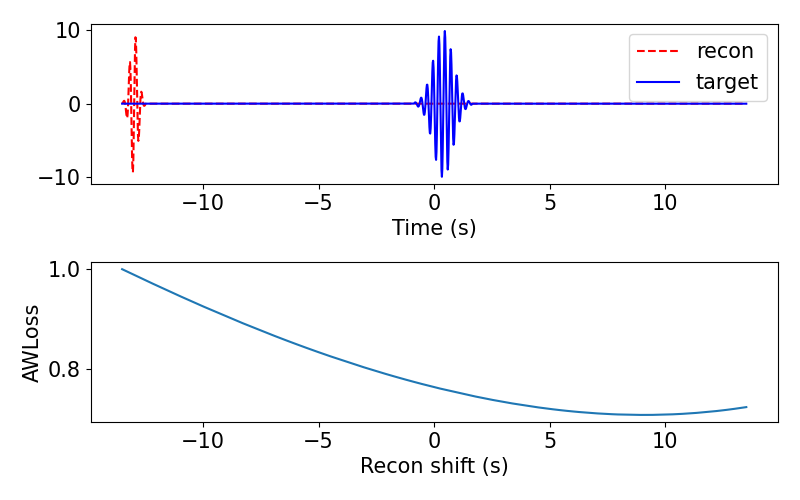

In [122]:
%matplotlib ipympl
plt.rcParams.update({'font.size': 15}) 

awloss       = AWLoss(epsilon=0., store_filters=False, method="fft", filter_dim=1, filter_scale=15, reduction="mean", std=9e-2)
mseloss      = nn.MSELoss(reduction="mean")

lags = torch.linspace(-1350, 1350, 1500)
offsets = torch.linspace(-1350, 1350, len(lags)-100)
midoff = int(len(offsets)/2)
midlag = int(len(lags)/2)

target = ricker_mount(len(lags), [midoff-100, midoff-50, midoff, midoff+50, midoff+100])
target = torch.tensor(10*tone_burst(1e-7, 7e5, 10, len(lags), offset=midoff), dtype=torch.float32).unsqueeze(0)

awlosses = []
recon_signals = []

for i in range(0, len(offsets), 1):
    # inp = ricker_mount(len(lags), [i])
    inp = torch.tensor(10*tone_burst(1e-7, 7e5, 4, len(lags), offset=i), dtype=torch.float32).unsqueeze(0)
    
    if i == 0:
        input = inp
    recon_signals.append(inp)


    aw = awloss(inp, target)  # reverse
    # aw = awloss(target, inp)  # forward
    awlosses.append(aw.item())

def getRecon(idx):
    return recon_signals[int(idx)]

def getTarget():
    return target



fig, axs = plt.subplots(2, 1, figsize=(8, 5))
axs[0].plot(lags/100, input[0], "r--", label="recon")
# controls = iplt.plot(lags/100, getRecon, idx=np.arange(0, len(offsets), 1))
axs[0].plot(lags/100, target[0], "b-", label="target")
axs[0].legend()
axs[1].plot(offsets/100, awlosses/ np.max(np.abs(np.asarray(awlosses))))
axs[0].set_xlabel("Time (s)")
axs[1].set_xlabel("Recon shift (s)")
axs[1].set_ylabel("AWLoss")
fig.tight_layout()
plt.show()